<a href="https://colab.research.google.com/github/LaTsa99/DeepMinds/blob/master/DeepMinds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing necessary modules for data preprocessing**

In [1]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

**Downloading the zip file containing our training data**

In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1UM65-NZoXAr3lydSkmX2OmHm63-PfepX -O /tmp/girls.zip

Downloading...
From: https://drive.google.com/uc?id=1UM65-NZoXAr3lydSkmX2OmHm63-PfepX
To: /tmp/girls.zip
126MB [00:01, 64.1MB/s]


**Unzipping the zip file containing the training data**

In [3]:
local_zip = '/tmp/girls.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

**Creating path strings to easily import the train data**

In [4]:
base_dir = os.path.join('/tmp', 'girls')

train_dir = os.path.join(base_dir, 'train')
train_bikini_dir = os.path.join(train_dir, 'bikini')
train_long_dir = os.path.join(train_dir, 'long')

valid_dir = os.path.join(base_dir, 'valid')
valid_bikini_dir = os.path.join(valid_dir, 'bikini')
valid_long_dir = os.path.join(valid_dir, 'long')

test_dir = os.path.join(base_dir, 'test')
test_bikini_dir = os.path.join(test_dir, 'bikini')
test_long_dir = os.path.join(test_dir, 'long')

**Querrying the filenames into variables**

In [5]:
bikini_train_fnames = os.listdir(train_bikini_dir)
bikini_valid_fnames = os.listdir(valid_bikini_dir)
bikini_test_fnames = os.listdir(test_bikini_dir)

long_train_fnames = os.listdir(train_long_dir)
long_valid_fnames = os.listdir(valid_long_dir)
long_test_fnames = os.listdir(test_long_dir)

**Setting the input image dimensions**

In [6]:
# https://keras.io/api/applications/
# ResNet101V2 224x224
# NASNetLarge 331x331
# VGG19 224x224
# InceptionV3 299x299
img_height = 299
img_width = 299

**Generating our data and making data generators**

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=10, zoom_range=0.2, horizontal_flip=True, rotation_range=20)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary')
test_generator  = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary')

Found 1572 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 266 images belonging to 2 classes.


In [8]:
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [11]:
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
for layer in base_model.layers:
  layer.trainable = False

# TODO: adam, rmsprop, adagrad, adadelta
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

In [13]:
early_stopping = EarlyStopping(patience=10, verbose=1, min_delta=0.001)
checkpointer = ModelCheckpoint(filepath='model.hdf5', save_best_only=True, verbose=1)
tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)

In [14]:
model.fit(train_generator, steps_per_epoch=79, validation_data=valid_generator, validation_steps=26, epochs=5, callbacks=[early_stopping, checkpointer, tb])

Epoch 1/5
 1/79 [..............................] - ETA: 0s - loss: 2.2881 - accuracy: 0.4000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
79/79 [==============================] - ETA: 0s - loss: 1.3724 - accuracy: 0.8963
Epoch 00001: val_loss improved from inf to 0.22064, saving model to model.hdf5
79/79 [==============================] - 45s 564ms/step - loss: 1.3724 - accuracy: 0.8963 - val_loss: 0.2206 - val_accuracy: 0.9596
Epoch 2/5
79/79 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.9421
Epoch 00002: val_loss did not improve from 0.22064
79/79 [==============================] - 43s 541ms/step - loss: 0.3949 - accuracy: 0.9421 - val_loss: 0.2719 - val_accuracy: 0.9423
Epoch 3/5
79/79 [==============================] - ETA: 0s -

In [15]:
# TODO freeze layers
# ResNet101V2 
# NASNetLarge 
# VGG19 
# InceptionV3 172
for layer in model.layers[:172]:
  layer.trainable = False
for layer in model.layers[172:]:
  layer.trainable = True

model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
model.fit(train_generator, steps_per_epoch=79, validation_data=valid_generator, validation_steps=26, epochs=5, callbacks=[early_stopping, checkpointer, tb])

Epoch 1/5
79/79 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9408
Epoch 00001: val_loss did not improve from 0.11401
79/79 [==============================] - 46s 586ms/step - loss: 0.1975 - accuracy: 0.9408 - val_loss: 84.5170 - val_accuracy: 0.7942
Epoch 2/5
79/79 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.9676
Epoch 00002: val_loss did not improve from 0.11401
79/79 [==============================] - 45s 565ms/step - loss: 0.1020 - accuracy: 0.9676 - val_loss: 36.9648 - val_accuracy: 0.8481
Epoch 3/5
79/79 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9733
Epoch 00003: val_loss did not improve from 0.11401
79/79 [==============================] - 45s 566ms/step - loss: 0.1310 - accuracy: 0.9733 - val_loss: 2137.2598 - val_accuracy: 0.4615
Epoch 4/5
79/79 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 0.9701
Epoch 00004: val_loss did not improve from 0.11401
79/79 [================

In [16]:
from keras.models import load_model

model = load_model('model.hdf5')
test_err = model.evaluate(test_generator)
print('Test error:', test_err[0], 'Test accuracy:', test_err[1])

14/14 [==============================] - 3s 216ms/step - loss: 0.1387 - accuracy: 0.9549
Test error: 0.13865961134433746 Test accuracy: 0.9548872113227844


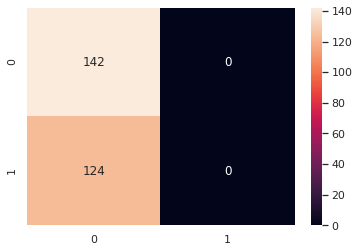

In [ ]:
#conf matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#print(test_generator.labels)
preds = model.predict(test_generator)
conf = confusion_matrix(test_generator.labels, np.argmax(preds, axis=1))
sns.set()
sns.heatmap(conf, annot=True, fmt='d')

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predicter(img_path):
  test0  = image.load_img(img_path, target_size=(img_height, img_width))
  x = image.img_to_array(test0)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  pred = model.predict(x)
  if pred > 0.5:
    print('Approved')
  else:
    print('Dress up!')

In [ ]:
predicter('download (1).jpeg')

Dress up!


In [ ]:
# TODO: tensorboard
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
import gc
gc.collect()

3601

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________